In [1]:
import pandas as pd
import numpy as np
import calculate
from calculate import gini

In [2]:
# Specify career len to export file for
# CAREER_LENGTH = 15
# Specify how long is the early career. Impacts which papers we take into account for early productivity and quality
# EARLY_CAREER_LEN = 3
# EARLY_CAREER_LEN_LIST = [1, 2, 3, 4, 5]
EARLY_CAREER_LEN_LIST = [3,5,7,9,11,12]
# For early career work, when do we stop counting citations. Impacts recognition
# RECOGNITION_CUT_OFF = 5
# RECOGNITION_CUT_OFF_LIST = [3, 4, 5, 6, 7, 8, 9]
# RECOGNITION_CUT_OFF_LIST = [3, 5]
RECOGNITION_CUT_OFF_LIST = [3,5,7,9,11,12]
# Success after 15 years. Impacts when we stop counting citations
SUCCESS_CUTOFF = 15
# Length of observed career for dropouts
# (1-3), middle career (4-9), late career (10-15)

# TODO: for multiple dropout intervals code does not work!!!
# CAREER_LENGTH_DROPOUTS_LIST = [ (0, 15), (0, 3), (4, 9), (10, 15)] #,
CAREER_LENGTH_DROPOUTS_LIST = [(0, 15)]
# CAREER_LENGTH_DROPOUTS = 15
INACTIVE_TIME_DROPOUTS = 10

# Specify the first and last year we consider in our analysis
START_YEAR = 1970
LAST_START_YEAR = 2000

In [3]:
# assert(INACTIVE_TIME_DROPOUTS < CAREER_LENGTH_DROPOUTS), "Time observed for dropouts has to be smaller than the whole window!"

In [4]:
# assert(CAREER_LENGTH >= EARLY_CAREER_LEN), "Early career len too long"

## 1. Load data

In [31]:
authorPublicationData = pd.read_csv('./data/author_publications_2017_asiansAsNone.txt')
arxiv_pubid = pd.read_csv('derived-data/arxiv_pubid_2017.csv', header=None, names=['pub_id'])
authorPublicationData.head()

,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [32]:
print(authorPublicationData.shape)
# same as dropping author, pub_id and year
authorPublicationData.drop_duplicates(subset=['author','pub_id'], inplace=True)
print(authorPublicationData.shape)
authorPublicationData = authorPublicationData.loc[~authorPublicationData.pub_id.isin(arxiv_pubid['pub_id'])]
print(authorPublicationData.shape)

(9471668, 3)
(9467149, 3)
(9317809, 3)


In [33]:
authorPublicationData['pub_id'].nunique()

3029829

In [34]:
authorCitationsData = pd.read_csv('./data/citations_2017_asiansAsNone.txt')
authorCitationsData.head()

,id1,id2,year
0,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,5065f1e8-0e2e-4e20-9866-2b5067d321dc,1990.0
1,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,cf862fd8-9204-4e44-9639-2d067c247539,1990.0
2,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,f19127f8-3d3a-4a9e-9580-c1d3e1e05141,1990.0
3,03b1d66a-b1fc-4d99-9904-9405695cc2ae,09991de0-c00f-49cf-a88a-6515943b0843,1994.0
4,03b1d66a-b1fc-4d99-9904-9405695cc2ae,156173f6-35eb-44f6-bc75-7c205153b6f0,1994.0


In [35]:
print(authorCitationsData.shape)
authorCitationsData.drop_duplicates(inplace=True)
print(authorCitationsData.shape)
authorCitationsData = authorCitationsData.loc[(~authorCitationsData.id1.isin(arxiv_pubid['pub_id']))| 
                                             (~authorCitationsData.id2.isin(arxiv_pubid['pub_id']))]
print(authorCitationsData.shape)

(8938798, 3)
(8938798, 3)
(8936448, 3)


In [37]:
print('Authors#      - ',authorPublicationData['author'].nunique())
print('Years#        - ',authorPublicationData['year'].nunique())
print('Publications# - ',authorPublicationData['pub_id'].nunique())

Authors#      -  1694302
Years#        -  83
Publications# -  3029829


In [38]:
# venue data
publication_venues_rank = pd.read_csv('derived-data/publication-venues-rank.csv')

In [39]:
publication_venues_rank.head()

,pub_id,year,venue,h5_index,ranking,deciles,quantiles
0,001c58d3-26ad-46b3-ab3a-c1e557d16821,2011,visual analytics science and technology,62.0,273.5,2.0,1.0
1,001c8744-73c4-4b04-9364-22d31a10dbf1,2009,pattern recognition and machine intelligence,23.0,1203.0,6.0,3.0
2,00701b05-684f-45f9-b281-425abfec482c,2011,international symposium on computer and inform...,18.0,1486.5,7.0,3.0
3,00964544-cbe2-4da9-bb5a-03333160eb34,2014,international conference on computer vision an...,8.0,2117.5,9.0,4.0
4,00bcf2d5-1592-46b0-81fd-933f90b5ecca,2002,international conference on conceptual structures,45.0,265.0,2.0,1.0


## 2. Career length and dropouts

In [40]:
groupByAuthor = authorPublicationData.groupby(['author'])

groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['pub_id'].count()

In [41]:
authorGroupedData = groupByAuthorMinYearData.to_frame(name='start_year')
authorGroupedData['end_year'] = groupByAuthorMaxYearData
authorGroupedData['total_num_pub'] = groupByAuthorCountPublicationsData
authorGroupedData = authorGroupedData.reset_index()
print('Total rows -                ', authorGroupedData.shape)

# authorGroupedData = authorGroupedData[authorGroupedData["start_year"] >= START_YEAR]
# print('After removing all < 1970 - ', authorGroupedData.shape)

authorGroupedData = authorGroupedData.drop_duplicates()
print('After removing duplicates - ', authorGroupedData.shape)

authorGroupedData = authorGroupedData.dropna(how='any')
print("After droping na -          ", authorGroupedData.shape)

authorGroupedData.head()

Total rows -                 (1694302, 4)
After removing duplicates -  (1694302, 4)
After droping na -           (1694302, 4)


,author,start_year,end_year,total_num_pub
0,'maseka lesaoana,2001,2015,2
1,(max) zong-ming cheng,2009,2011,2
2,(zhou) bryan bai,2011,2012,2
3,a aart blokhuis,1992,2005,2
4,a ahrabian,2017,2017,1


In [42]:
# Adding 1 here to have career length be at least one. So 3 years career means year1, year2, year3.
authorGroupedData["career_length"] = authorGroupedData['end_year'] - authorGroupedData['start_year'] + 1

In [43]:
credible_authors = authorGroupedData

### Label authors that drop out

In [44]:
print(f"Label authors with {INACTIVE_TIME_DROPOUTS} years inacitivity in a {CAREER_LENGTH_DROPOUTS_LIST} years window as dropouts")

Label authors with 10 years inacitivity in a [(0, 15)] years window as dropouts


In [45]:
combined_pubs = authorPublicationData.merge(credible_authors[['author', 'start_year']], on='author', how='inner')
# TODO remove this, its the same as early career publications
print(combined_pubs.shape)

(9317809, 4)


In [46]:
def list_append(lst, item):
    lst.append(item)
    return lst

In [47]:
# %%time
# This code is potato...
for start, end in CAREER_LENGTH_DROPOUTS_LIST:
    combined_pubs_grouped = combined_pubs[(combined_pubs.year >= combined_pubs.start_year + start) &
                                    (combined_pubs.year <= combined_pubs.start_year + end)]   
    # for every 2 consecutive years the author has published (nxt and prev) find a difference (absence time)
    # we artificially add two value: career start + 15 and career start, as limiters of our observation window
    # this will add 0 values in the begining for the first year
    combined_pubs_grouped = combined_pubs_grouped.groupby('author')['year', 'start_year'].apply(
        lambda x: [nxt - prev for prev, nxt in zip(sorted(list_append(list(x['year']),x['start_year'].iloc[0]+start)), 
                                                   sorted(list_append(list(x['year']),x['start_year'].iloc[0]+  end)))])
    combined_pubs_grouped = combined_pubs_grouped.reset_index()
    combined_pubs_grouped.rename({0:f'absence_list-{start}-{end}'}, inplace=True, axis='columns')
    combined_pubs_grouped[f'max_absence-{start}-{end}'] = combined_pubs_grouped[f'absence_list-{start}-{end}'].apply(max)
    combined_pubs_grouped[f'avg_absence-{start}-{end}'] = combined_pubs_grouped[f'absence_list-{start}-{end}'].apply(np.mean)
    
    credible_authors = credible_authors.merge(combined_pubs_grouped[['author', f'max_absence-{start}-{end}', 
                                                                     f'avg_absence-{start}-{end}']], on='author', how='left')
    credible_authors[f'max_absence-{start}-{end}'] = credible_authors[f'max_absence-{start}-{end}'].fillna(end-start+1)
    credible_authors[f'avg_absence-{start}-{end}'] = credible_authors[f'avg_absence-{start}-{end}'].fillna(end-start+1)
    
    # TODO: Should i also add the start year into the calculation? Now i only have end year included

In [48]:
credible_authors['dropped_after_10'] = credible_authors['max_absence-0-15'].apply(lambda x: False if x < 10 else True)

In [49]:
credible_authors['max_absence-0-15'].value_counts(dropna=False)

15    914640
14    117603
13    103032
12     84408
11     74363
10     65665
9      61499
8      60150
7      47175
6      42213
5      36608
4      32376
3      27481
2      21164
1       5925
Name: max_absence-0-15, dtype: int64

In [50]:
credible_authors.shape

(1694302, 8)

In [51]:
credible_authors['dropped_after_10'].value_counts()

True     1359711
False     334591
Name: dropped_after_10, dtype: int64

In [52]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10'],
      dtype='object')

### Gender

In [53]:
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')
credible_authors = credible_authors.merge(gender, left_on='author', right_on='name', how='left')
credible_authors.drop('name', axis=1, inplace=True)

credible_authors.gender.value_counts()

m       791347
none    648819
f       254136
Name: gender, dtype: int64

In [54]:
credible_authors.gender.value_counts()

m       791347
none    648819
f       254136
Name: gender, dtype: int64

In [55]:
gender.head()

,name,gender
0,gareth beale,m
1,graeme earl,m
2,altaf hossain,m
3,faisal zaman,m
4,m. nasser,none


### Save filtered data about authors, and cleaned publications

In [56]:
credible_authors[credible_authors.start_year >= START_YEAR].to_csv('derived-data/authors-scientific.csv', index=False, encoding='utf-8')
credible_authors.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15,dropped_after_10,gender
0,'maseka lesaoana,2001,2015,2,15,14,5.0,True,none
1,(max) zong-ming cheng,2009,2011,2,3,13,5.0,True,none
2,(zhou) bryan bai,2011,2012,2,2,14,5.0,True,none
3,a aart blokhuis,1992,2005,2,14,13,5.0,True,none
4,a ahrabian,2017,2017,1,1,15,7.5,True,none


In [57]:
authorPublicationData.to_csv('derived-data/author-publications.csv', index=False)

In [58]:
authorPublicationData.shape

(9317809, 3)

## 3. Generate a new citation network

### Generate Author->Paper network

In [59]:
# We need data about how many times an author has been cited
# For every authors publication, i merge all citations
# Doesnt contain uncited papers
final_citation_count_from_ids = authorPublicationData.merge(authorCitationsData, left_on='pub_id', 
                                                            right_on='id2', how='inner', suffixes=('_pub', '_cit'))

In [ ]:
print(final_citation_count_from_ids.shape)

(26402668, 6)


In [ ]:
final_citation_count_from_ids.drop_duplicates(inplace=True)

In [ ]:
print(final_citation_count_from_ids.shape)

(26402668, 6)


#### Remove errors in citation data (years published vs years cited)

In [ ]:
# Published before cited - NORMAL
print(final_citation_count_from_ids.shape)
num_normal = final_citation_count_from_ids[final_citation_count_from_ids.year_pub <= final_citation_count_from_ids.year_cit].shape
print(num_normal)

(26402668, 6)
(26240257, 6)


In [ ]:
# Published after cited - WRONG
num_wrong = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].shape
print(num_wrong)

(162411, 6)


In [ ]:
print("Percentage of citations to be removed: ", num_wrong[0]*100/(num_normal[0]+num_wrong[0]))
print("Less than one percent")

Percentage of citations to be removed:  0.6151310163048673
Less than one percent


In [ ]:
cit_wrong_df = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit]

In [ ]:
cit_wrong = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].index

In [ ]:
final_citation_count_from_ids.drop(cit_wrong, inplace=True)

assert num_normal[0] == final_citation_count_from_ids.shape[0], "The number of citations doesnt match"

In [ ]:
final_citation_count_from_ids.columns

Index(['author', 'year_pub', 'pub_id', 'id1', 'id2', 'year_cit'], dtype='object')

#### Save

In [ ]:
# final_citation_count_from_ids.to_csv('./data/authors_cited_by_papers_2017_asiansAsNone_by_daniel.txt',
#                                      columns=['author', 'year_pub', 'pub_id', 'id1', 'year_cit'], index=False)

final_citation_count_from_ids[['author', 'id1', 'id2', 'year_cit']].drop_duplicates().to_csv('derived-data/author-paper-citations-cleaned.csv', 
                                                                                   index=False)

# final_citation_count_from_ids.drop_duplicates(subset=['author_cited', 'pub_id_cited', 'pub_id_citing', 'author_citing'],
#                                               inplace=True)

In [ ]:
# drop duplicates on id1,id2 because we only care about paper->paper citations
paper_citation_count = final_citation_count_from_ids.drop_duplicates(subset=['id1', 'id2']).groupby('id2')['id1'].count()
paper_citation_count.to_csv('derived-data/paper-citation-count.csv')

/home/danielkostic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


Its important to keep using this file for citations. As it has bad entries removed

### Group citations over authors and years

In [ ]:
citations_year_auth = final_citation_count_from_ids.groupby(['author', 'year_cit'])['id1'].count()

In [ ]:
citations_year_auth.head()

author            year_cit
'maseka lesaoana  2004.0      1
                  2005.0      1
                  2006.0      3
                  2007.0      1
                  2008.0      1
Name: id1, dtype: int64

In [ ]:
citations_year_auth = citations_year_auth.reset_index()
citations_year_auth = citations_year_auth.rename(columns={'id1':'cit_count'})

citations_year_auth[['author', 'year_cit', 'cit_count']].to_csv('derived-data/authors-perYear-citations.csv', index=False)

In [ ]:
citations_year_auth = citations_year_auth.groupby(['author', 'year_cit'])['cit_count'].sum()
citations_year_auth = citations_year_auth.reset_index()

## Early career analysis

In [ ]:
# Doesnt contain uncited papers
# Does not contain multiple authors per one citation
combined = final_citation_count_from_ids.merge(credible_authors[['author', 'start_year']], on='author', how='inner')
# TODO Is this 'inner' here good?

In [ ]:
early_career_publications = authorPublicationData.merge(credible_authors[['author', 'start_year']], on='author', how='left')

In [ ]:
print(early_career_publications.author.nunique())
print(early_career_publications.pub_id.nunique())
print(early_career_publications.shape[0])

1694302
3029829
9317809


In [ ]:
print(combined.author.nunique())
print(combined.pub_id.nunique())
print(combined.shape[0])

866378
1367718
26240257


In [ ]:
combined.head()

,author,year_pub,pub_id,id1,id2,year_cit,start_year
0,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,49ec0c15-7a9d-4378-a26a-f5063567b519,001c8744-73c4-4b04-9364-22d31a10dbf1,2013.0,2009
1,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,ae0b4e3d-305d-4fb8-9847-60dcc9a9ec44,001c8744-73c4-4b04-9364-22d31a10dbf1,2014.0,2009
2,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,49ec0c15-7a9d-4378-a26a-f5063567b519,001c8744-73c4-4b04-9364-22d31a10dbf1,2013.0,2006
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,ae0b4e3d-305d-4fb8-9847-60dcc9a9ec44,001c8744-73c4-4b04-9364-22d31a10dbf1,2014.0,2006
4,faisal zaman,2012,d28d236e-57c4-4489-beec-6c5b2163e711,16059f3f-e711-45d8-a33c-09a595c58ecf,d28d236e-57c4-4489-beec-6c5b2163e711,2014.0,2006


In [ ]:
combined.drop_duplicates(subset=['author', 'id1', 'id2'], inplace=True)

In [ ]:
combined.columns

Index(['author', 'year_pub', 'pub_id', 'id1', 'id2', 'year_cit', 'start_year'], dtype='object')

In [ ]:
from memory import show_mem_usage

In [ ]:
show_mem_usage()

['___', '___', '_73', '_73'] 106.035MB
['authorPublicationData', 'authorPublicationData'] 1706.025MB
['authorCitationsData', 'authorCitationsData'] 1805.162MB
['publication_venues_rank', 'publication_venues_rank'] 524.862MB
['groupByAuthorMinYearData', 'groupByAuthorMinYearData'] 138.653MB
['groupByAuthorMaxYearData', 'groupByAuthorMaxYearData'] 138.653MB
['groupByAuthorCountPublicationsData', 'groupByAuthorCountPublicationsData'] 138.653MB
['authorGroupedData', 'authorGroupedData'] 192.870MB
['credible_authors', 'credible_authors'] 330.253MB
['combined_pubs', 'combined_pubs'] 1780.568MB
['combined_pubs_grouped', 'combined_pubs_grouped'] 336.118MB
['arxiv_pubid', 'arxiv_pubid'] 4.516MB
['gender', 'gender'] 233.282MB
['final_citation_count_from_ids', 'final_citation_count_from_ids'] 9885.598MB
['cit_wrong_df', 'cit_wrong_df'] 61.290MB
['cit_wrong', 'cit_wrong'] 1.299MB
['paper_citation_count', 'paper_citation_count'] 138.140MB
['citations_year_auth', 'citations_year_auth'] 383.687MB
['c

### Author order
The size of this df is about 3M, corresponding to the number of unique `pub_id` we have in the dataset

In [ ]:
author_order = pd.read_csv('derived-data/publication_authors_order_2017.csv')
print(author_order.columns)
print(author_order.shape)

Index(['pub_id', 'year', 'authors', 'num_authors', 'is_alpha', 'first_author'], dtype='object')
(3078230, 6)


In [ ]:
author_order = author_order.merge(credible_authors[['author', 'start_year']], left_on='first_author', 
                                  right_on='author', how='left')
author_order = author_order.drop('first_author', axis='columns')

In [ ]:
for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
    author_order_early = author_order[(author_order.year < author_order.start_year + EARLY_CAREER)]
    author_order_early = author_order_early.groupby('author').agg({'pub_id':'count'}).reset_index()
    author_order_early.rename({'pub_id': f'ec_first_auth_{EARLY_CAREER}'}, axis='columns', inplace=True)
    credible_authors = credible_authors.merge(author_order_early, on='author', how='left')
    credible_authors[f'ec_first_auth_{EARLY_CAREER}'] = credible_authors[f'ec_first_auth_{EARLY_CAREER}'].fillna(0)

### Team size

In [ ]:
for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
    early_career_publications_filtered = early_career_publications[(
        early_career_publications.year < early_career_publications.start_year + EARLY_CAREER)]
    paper_team_size = early_career_publications_filtered.groupby('pub_id').agg({'author' : 'nunique'}).reset_index()
    paper_team_size = paper_team_size.rename({'author': f'team_size_{EARLY_CAREER}'}, axis='columns')
    early_career_publications_filtered = early_career_publications_filtered.merge(paper_team_size, on='pub_id', how='left')
    team_size_median = early_career_publications_filtered.groupby('author').agg({f'team_size_{EARLY_CAREER}': 'median'}).reset_index()
    team_size_median = team_size_median.rename({f'team_size_{EARLY_CAREER}': f'team_size_median_{EARLY_CAREER}'}, axis='columns')
    team_size_mean = early_career_publications_filtered.groupby('author').agg({f'team_size_{EARLY_CAREER}': 'mean'}).reset_index()
    team_size_mean = team_size_mean.rename({f'team_size_{EARLY_CAREER}': f'team_size_mean_{EARLY_CAREER}'}, axis='columns')

    credible_authors = credible_authors.merge(team_size_median, on='author', how='left')
    credible_authors = credible_authors.merge(team_size_mean, on='author', how='left')

In [ ]:
early_career_publications_filtered.shape

In [ ]:
team_size_median.shape

In [ ]:
credible_authors.columns

#### Per Year

In [198]:
# this has no effect, arxiv removed beforehand
# print(authorPublicationData.shape)
# print(authorPublicationData.loc[~authorPublicationData.pub_id.isin(arxiv_pubid['pub_id'])].shape)

(9317809, 3)
(9317809, 3)


In [188]:
team_size = authorPublicationData.groupby(['year', 'pub_id']).size().reset_index(name='team_size')
team_size.head()

,year,pub_id,team_size
0,1936,0c5685ec-37dd-4267-a690-ce5bbbbffb00,1
1,1936,566fc941-6ba6-41ab-b579-ad3d7fe4ca27,1
2,1936,62c68236-b9e5-44dd-b299-e0d03c3e7bf4,1
3,1936,8581f824-2333-4b5f-b277-a4020281a7f8,1
4,1936,c45bdb20-3d36-4d7d-8a83-203e3d3bff9e,1


In [205]:
team_size_year = team_size.groupby('year').agg({'team_size': 'mean'}).reset_index()
team_size_year.head()

,year,team_size
0,1936,1.000000
1,1937,1.000000
2,1938,1.000000
3,1939,1.000000
4,1940,1.333333


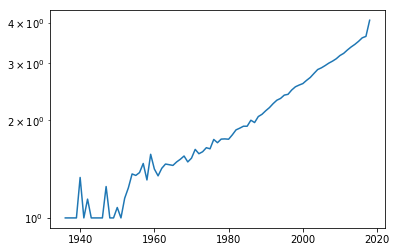

In [210]:
import matplotlib.pyplot as plt
plt.plot(team_size_year['year'], team_size_year['team_size'])
plt.yscale('log')
plt.savefig('./fig/average_team_size_across_years.png')

In [207]:
team_size_year.to_csv('derived-data/team_size_avg_per_year.csv', index=None)

Are all authors included here? Also those without gender?

### Rolling citations

In [149]:
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count().reset_index()
author_year_numPub = author_year_numPub.rename(columns={'pub_id':'num_pub'})

In [150]:
all_years = credible_authors.start_year.unique()
start_years = [year for year in all_years if START_YEAR <= year <= LAST_START_YEAR]
start_years = sorted(start_years)

In [151]:
counts0 = credible_authors[['author', 'start_year']].copy()
#filter out start years
counts0 = counts0[counts0['start_year'].isin(start_years)]
counts0['year'] = counts0['start_year'].apply(lambda x: [x+i for i in range(0, 15)])
counts = pd.DataFrame(counts0['year'].tolist(), index=counts0['author']).stack().reset_index(
    level=1, drop=True).reset_index(name='year')[['year','author']]
counts = counts.merge(credible_authors[['author', 'start_year', 'end_year', 'gender']], on='author', how='inner')
counts['career_age'] = counts['year'] - counts['start_year'] + 1
counts['year'] = counts['year'].astype('int32')

In [152]:
#citations window
WINDOW_SIZE = 3
df_list = []
for year in start_years:
    df_year = combined[combined.start_year == year]
    for y in range(year, year+13): #y is the first year we count for
        df_window = df_year[(df_year.year_pub>=y) & (df_year.year_cit>=y)& (df_year.year_pub<=y)& (df_year.year_cit<=y+WINDOW_SIZE)]
        df_window = df_window.groupby('author').agg({'id1': 'count'}).reset_index()
        df_window['year'] = y
        df_window = df_window.rename({'id1' : f'cit_{WINDOW_SIZE}'}, axis=1)
        df_list.append(df_window)
df_cit_3_window = pd.concat(df_list).sort_values(by=['author', 'year'])

In [153]:
counts = counts.merge(df_cit_3_window, on=['author', 'year'], how='left')
counts['cit_3'] = counts['cit_3'].fillna(0)

In [154]:
citations_year_auth.rename(columns={'year_cit':'year', 'cit_count':'num_cit'}, inplace=True)

In [155]:
# merge in publications
counts = counts.merge(author_year_numPub, on=['author', 'year'], how='left')
counts['num_pub'] = counts['num_pub'].fillna(0)
# merge in citations
counts = counts.merge(citations_year_auth, on=['author', 'year'], how='left')
counts['num_cit'] = counts['num_cit'].fillna(0)

In [156]:
counts = calculate.calculate_cumulative_for_authors(counts, 'num_cit')
counts = calculate.calculate_cumulative_for_authors(counts, 'num_pub')

In [ ]:
counts['career_duration'] = counts['end_year']-counts['start_year'] + 1

In [ ]:
# %%time
#publication window
# TODO sort?!
counts['win_num_pub'] = counts.groupby('author')['num_pub'].transform(lambda x: x.rolling(3, min_periods=3).sum().shift(-2))

In [ ]:
counts.columns

Index(['year', 'author', 'start_year', 'end_year', 'gender', 'career_age',
       'cit_3', 'num_pub', 'num_cit', 'cum_num_cit', 'cum_num_pub',
       'career_duration', 'win_num_pub'],
      dtype='object')

In [ ]:
# %%time
# #unpack list of values
# df = df['year_cit'].apply(pd.Series) \
#     .join(df) \
#     .drop(["year_cit"], axis = 1) \
#     .melt(id_vars = ['author', 'year_pub'], value_name = "year_cit") \
#     .drop("variable", axis = 1) \
#     .dropna()

### Early, mid and late papers analysis - citations

In [ ]:
# %%time
# publish_years = [[0,3], [3,6], [6,9], [0,1], [3,4], [6,7]]
publish_years = [[i, i+1] for i in range(0,15)]
for start,end in publish_years:
    first_3 = combined[(combined.year_pub >= combined.start_year + start) & (combined.year_pub < combined.start_year + end)]
    first_3 = first_3.groupby(['author', 'year_cit']).agg({'id1': 'count'}).reset_index()
    first_3 = first_3.rename({'year_cit' : 'year', 'id1': f'ec_cit_{start}_{end}'}, axis=1)
    counts = counts.merge(first_3, on=['author', 'year'], how='left')
    counts[f'ec_cit_{start}_{end}'] = counts[f'ec_cit_{start}_{end}'].fillna(0)

In [ ]:
# calculate cumulative out of absolute
for start,end in publish_years:
    counts[f'ec_cit_{start}_{end}_cum'] = counts.sort_values(['author', 'career_age']).groupby('author')[f'ec_cit_{start}_{end}'].transform(pd.Series.cumsum)

In [ ]:
# calc gini for absolute => 7
author_gini_early_work = counts.groupby(['start_year', 'career_age']).agg(
    {f'ec_cit_{start}_{end}': gini for start,end in publish_years}).reset_index()

In [ ]:
author_gini_early_work.head()

In [ ]:
# calc gini for cumulative => 7
author_gini_early_work_cum = counts.groupby(['start_year', 'career_age']).agg(
    {f'ec_cit_{start}_{end}_cum': gini for start,end in publish_years}).reset_index()

In [ ]:
author_gini_early_work_cum.head()

In [ ]:
counts.columns

In [ ]:
counts.to_csv(f'derived-data/citations_window_{WINDOW_SIZE}.csv', index=None)

### Venues

In [ ]:
early_career_venues = early_career_publications.merge(publication_venues_rank[[
    'pub_id', 'h5_index', 'ranking', 'deciles', 'quantiles']], on='pub_id', how='inner')

In [ ]:
early_career_venues.author.nunique()

In [ ]:
EARLY_CAREER_LEN_LIST

In [ ]:
# TODO including the MAX and MIN values as missing. Check this. also what to do with ranking?
def quantile_binary(quant): 
    return quant <= 3

for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#     EARLY_CAREER = 3
    early_career_venues_ec = early_career_venues[early_career_venues.year < early_career_venues.start_year + EARLY_CAREER]
    early_career_venues_gr = early_career_venues_ec.groupby('author').agg({
        'h5_index': 'max',
    #     'ranking': 'min',
        'deciles': 'min',
        'quantiles': 'min'}).rename(columns={
        'h5_index': f'h5_index_max_{EARLY_CAREER}', 
    #     'ranking': f'ranking_{EARLY_CAREER}',
        'deciles': f'deciles_min_{EARLY_CAREER}',
        'quantiles': f'quantiles_min_{EARLY_CAREER}'})
    early_career_venues_gr = early_career_venues_gr.reset_index()
    credible_authors = credible_authors.merge(early_career_venues_gr, on='author', how='left')

    credible_authors[f'h5_index_max_{EARLY_CAREER}'] = credible_authors[f'h5_index_max_{EARLY_CAREER}'].fillna(0)
    credible_authors[f'deciles_min_{EARLY_CAREER}'] = credible_authors[f'deciles_min_{EARLY_CAREER}'].fillna(10)
    credible_authors[f'quantiles_min_{EARLY_CAREER}'] = credible_authors[f'quantiles_min_{EARLY_CAREER}'].fillna(4)
    
    # CLAUDIA this should be TRUE if the author has AT LEAST one paper that exceeds the threshold
    credible_authors[f'quantiles_bin_{EARLY_CAREER}'] = credible_authors[f'quantiles_min_{EARLY_CAREER}'].apply(quantile_binary)
    
    # credible_authors[f'ranking_{EARLY_CAREER}'] = credible_authors[f'ranking_{EARLY_CAREER}'].fillna(0)

### Early degree

In [ ]:
# TODO: Can this be based on combined? Do we loose some info here

In [ ]:
for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
    combined_early_degree = combined[(combined.year_pub < combined.start_year + EARLY_CAREER)]

    combined_early_degree = combined_early_degree.drop_duplicates(subset=['author', 'pub_id'])

    combined_early_degree = combined_early_degree[['author', 'pub_id']]

    # authors_per_paper = combined_early_degree.groupby('pub_id')['author'].count().reset_index()
    # authors_per_paper.rename({"author":"early_career_degree"}, axis='columns', inplace=True)

    combined_early_degree = combined_early_degree.merge(combined, on='pub_id')

    combined_early_degree = combined_early_degree[combined_early_degree.author_x != combined_early_degree.author_y]
    combined_early_degree = combined_early_degree.drop_duplicates(subset=['author_x', 'author_y'])

    combined_early_degree = combined_early_degree.groupby('author_x')['author_y'].count().reset_index()

    combined_early_degree.rename({"author_x":"author", "author_y": f"early_career_degree_{EARLY_CAREER}"}, 
                                 axis='columns', inplace=True)

    credible_authors = credible_authors.merge(combined_early_degree, on='author', how='left')
    credible_authors[f"early_career_degree_{EARLY_CAREER}"] = credible_authors[f"early_career_degree_{EARLY_CAREER}"].fillna(0)

In [ ]:
combined_early_degree.sample(10)

### Early quality

In [124]:
for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
    combined_early_quality = combined[(combined.year_pub < combined.start_year + EARLY_CAREER) &
             (combined.year_cit < combined.start_year + SUCCESS_CUTOFF)]
    
    author_order_early = author_order[(author_order.year < author_order.start_year + EARLY_CAREER)]
    early_career_quality_first = combined_early_quality.loc[combined_early_quality['pub_id'].isin(author_order_early['pub_id'])]
    
    early_career_quality = combined_early_quality.groupby('author')['id1'].count()
    early_career_quality_first = early_career_quality_first.groupby('author')['id1'].count()

    early_career_quality = early_career_quality.rename(f'early_career_qual_{EARLY_CAREER}').reset_index()
    early_career_quality_first = early_career_quality_first.rename(f'early_career_qual_first_{EARLY_CAREER}').reset_index()
    
    credible_authors = credible_authors.merge(early_career_quality, on='author', how='left')
    credible_authors = credible_authors.merge(early_career_quality_first, on='author', how='left')
    
    credible_authors[f'early_career_qual_{EARLY_CAREER}'] = credible_authors[f'early_career_qual_{EARLY_CAREER}'].fillna(0)
    credible_authors[f'early_career_qual_first_{EARLY_CAREER}'] = credible_authors[
        f'early_career_qual_first_{EARLY_CAREER}'].fillna(0)

### Early recognition

In [125]:
for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
    for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
        if RECOGNITION_CUT != EARLY_CAREER: continue
        early_career_recognition = combined[(combined.year_pub < combined.start_year + EARLY_CAREER) &
                 (combined.year_cit < combined.start_year + RECOGNITION_CUT)]
        early_career_recognition = early_career_recognition.groupby('author')['id1'].count()
        col_name = f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}'
        early_career_recognition = early_career_recognition.rename(col_name)
        early_career_recognition = early_career_recognition.reset_index()
        credible_authors = credible_authors.merge(early_career_recognition, on='author', how='left')
        credible_authors[col_name] = credible_authors[col_name].fillna(0)

In [126]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'ec_first_auth_3', 'ec_first_auth_5', 'ec_first_auth_7',
       'ec_first_auth_9', 'ec_first_auth_11', 'ec_first_auth_12',
       'team_size_median_3', 'team_size_mean_3', 'team_size_median_5',
       'team_size_mean_5', 'team_size_median_7', 'team_size_mean_7',
       'team_size_median_9', 'team_size_mean_9', 'team_size_median_11',
       'team_size_mean_11', 'team_size_median_12', 'team_size_mean_12',
       'h5_index_max_3', 'deciles_min_3', 'quantiles_min_3', 'quantiles_bin_3',
       'h5_index_max_5', 'deciles_min_5', 'quantiles_min_5', 'quantiles_bin_5',
       'h5_index_max_7', 'deciles_min_7', 'quantiles_min_7', 'quantiles_bin_7',
       'h5_index_max_9', 'deciles_min_9', 'quantiles_min_9', 'quantiles_bin_9',
       'h5_index_max_11', 'deciles_min_11', 'quantiles_min_11',
       'quantiles_bin_11', 'h5_index_max_12', 'd

### Final success

In [127]:
combined_succ_after_15y = combined[combined.year_cit < combined.start_year + SUCCESS_CUTOFF]

In [128]:
succ_after_15y = combined_succ_after_15y.groupby('author')['id1'].count()

succ_after_15y = succ_after_15y.rename('succ_after_15y')
succ_after_15y = succ_after_15y.reset_index()
credible_authors = credible_authors.merge(succ_after_15y, on='author', how='left')
credible_authors['succ_after_15y'] = credible_authors['succ_after_15y'].fillna(0)

### H index

In [129]:
def h_index(citations):
    if len(citations) == 0: return 0
    if len(citations) == 1: return 1
    citations = sorted(citations, reverse=True)
    h_ind = 0
    for i, elem in enumerate(citations):
        if i+1 > elem:
            return i
        h_ind = i+1
    return h_ind

In [130]:
for param in [*EARLY_CAREER_LEN_LIST, SUCCESS_CUTOFF]:

    combined_h_index = combined[combined.year_cit < combined.start_year + param]

    combined_h_index = combined_h_index.groupby(['author', 'pub_id'])['id1'].count()

    combined_h_index = combined_h_index.reset_index()

    combined_h_index = combined_h_index.groupby('author')['id1'].apply(lambda x: h_index(x.values))

    combined_h_index = combined_h_index.rename(f'h-index_{param}')

    credible_authors = credible_authors.merge(combined_h_index.reset_index(), on='author', how='left')
    credible_authors[f'h-index_{param}'] = credible_authors[f'h-index_{param}'].fillna(0)

In [131]:
# TODO: test h-index

In [132]:
# %%time
for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
    early_career_publications_reduced = early_career_publications[early_career_publications.year <= 
                                                       early_career_publications.start_year + EARLY_CAREER]
    early_career_publications_ = early_career_publications_reduced.groupby('author').agg({'pub_id': 'nunique'}).reset_index()
    early_career_publications_ = early_career_publications_.rename({'pub_id':f'early_career_prod_{EARLY_CAREER}'}, axis='columns')
    credible_authors = credible_authors.merge(early_career_publications_, on='author', how='left')

### Early Coauthor max h-index

In [133]:
# for each paper in EC, calculate the h-index of all its authors
# This requires extra work
# We want to calculate the h index of coauthors at the time of publishing the paper
# for this we need an extra lookup table, where we store 
# all papers - authors - h-index at the time
# 

# final_citation_count_from_ids - we merge pub data with cit data, but "inner"
# this means we will not find papers with 0 citations in this df
# these papers dont impact the h-index, so this is okay

In [134]:
def author_h_index_in_year_X(authors, year_x):
#     print(year_x)
    combined_h = combined[(combined.year_cit < year_x) & (combined.author.isin(authors))]
    combined_h = combined_h.groupby(['author', 'pub_id']).agg({'id1': 'count'}).reset_index()
    author_hind_at_year = combined_h.groupby('author').agg({'id1': h_index}).reset_index()
    author_hind_at_year['year_pub'] = year_x
    author_hind_at_year = author_hind_at_year.rename({'id1': 'h-index'}, axis='columns')
    return author_hind_at_year

In [135]:
def author_h_index(author, year_x):
    combined_h = combined[(combined.year_cit < year_x) & (combined.author == author)]
    citations_count_list = combined_h.groupby(['pub_id']).agg({'id1': 'count'})['id1'].values
    return h_index(citations_count_list)

In [136]:
# %%time
papers_authors = combined[['author', 'year_pub']].drop_duplicates(subset=['author', 'year_pub'])

In [ ]:
# %%time
all_authors_hind = pd.DataFrame(columns=['author', 'h-index', 'year_pub'])
all_authors_hind['year_pub'] = all_authors_hind['year_pub'].astype('int64')
for year_x in papers_authors.year_pub.unique():
    authors = papers_authors[papers_authors.year_pub == year_x].author.values
    author_hind_at_year = author_h_index_in_year_X(authors, year_x)
    all_authors_hind = all_authors_hind.append(author_hind_at_year)

In [ ]:
papers_authors = papers_authors.merge(all_authors_hind, how='left')

In [ ]:
papers_authors['h-index'] = papers_authors['h-index'].fillna(0)

In [ ]:
for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
    combined_early_coauthor = combined[(combined.year_pub < combined.start_year + EARLY_CAREER)]

    combined_early_coauthor = combined_early_coauthor.drop_duplicates(subset=['author', 'pub_id'])

    combined_early_coauthor = combined_early_coauthor[['author', 'pub_id']]

    # merging with combined not to remove coauthors that are not in their early career
    combined_early_coauthor = combined_early_coauthor.merge(combined, on='pub_id')

    combined_early_coauthor = combined_early_coauthor[combined_early_coauthor.author_x != combined_early_coauthor.author_y]
    combined_early_coauthor = combined_early_coauthor.drop_duplicates(subset=['author_x', 'author_y'])

    # papers_authors contains h-index of authors in different publishing years
    combined_early_coauthor = combined_early_coauthor.merge(papers_authors, left_on=['author_y', 'year_pub'],
                                                            right_on=['author', 'year_pub'])

    combined_early_coauthor = combined_early_coauthor.groupby('author_x')['h-index'].max().reset_index()

    combined_early_coauthor.rename({"author_x":"author", "h-index": f"early_career_coauthor_max_hindex_{EARLY_CAREER}"}, 
                                 axis='columns', inplace=True)

    combined_early_coauthor = combined_early_coauthor[['author', f"early_career_coauthor_max_hindex_{EARLY_CAREER}"]]

    credible_authors = credible_authors.merge(combined_early_coauthor, on='author', how='left')
    credible_authors[f"early_career_coauthor_max_hindex_{EARLY_CAREER}"] = credible_authors[f"early_career_coauthor_max_hindex_{EARLY_CAREER}"].fillna(0)

In [ ]:
credible_authors.columns

### Early Coauthor max citations

In [ ]:
# for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#     combined_early_coauthor = combined[(combined.year_pub < combined.start_year + EARLY_CAREER)]

#     combined_early_coauthor = combined_early_coauthor.drop_duplicates(subset=['author', 'pub_id'])

#     combined_early_coauthor = combined_early_coauthor[['author', 'pub_id']]

#     combined_early_coauthor = combined_early_coauthor.merge(combined, on='pub_id')

#     combined_early_coauthor = combined_early_coauthor[combined_early_coauthor.author_x != combined_early_coauthor.author_y]
#     combined_early_coauthor = combined_early_coauthor.drop_duplicates(subset=['author_x', 'author_y'])

#     combined_early_coauthor = combined_early_coauthor.merge(credible_authors[['author', 'succ_after_15y']], left_on='author_y', right_on='author')
#     combined_early_coauthor = combined_early_coauthor.groupby('author_x')['succ_after_15y'].max().reset_index()

#     combined_early_coauthor.rename({"author_x":"author", "succ_after_15y": f"early_career_coauthor_max_cit_{EARLY_CAREER}"}, 
#                                  axis='columns', inplace=True)

#     combined_early_coauthor = combined_early_coauthor[['author', f"early_career_coauthor_max_cit_{EARLY_CAREER}"]]

#     credible_authors = credible_authors.merge(combined_early_coauthor, on='author', how='left')
#     credible_authors[f"early_career_coauthor_max_cit_{EARLY_CAREER}"] = credible_authors[f"early_career_coauthor_max_cit_{EARLY_CAREER}"].fillna(0)

In [ ]:
# drop
def drop_list_cols(drop_list):
    credible_authors.drop(drop_list, axis=1, inplace=True)
def drop_col(df, cols):
    df.drop(cols, axis='columns', inplace=True)

## Save

In [ ]:
# credible_authors.to_csv('derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv',
#                     index=False, encoding='utf-8')
credible_authors[credible_authors.start_year >= START_YEAR].to_csv('derived-data/authors-scientific-extended.csv',
                    index=False, encoding='utf-8')

In [ ]:
#backup
# credible_authors[credible_authors.start_year >= START_YEAR].to_csv('derived-data/authors-scientific-extended_all.csv',
#                     index=False, encoding='utf-8')

In [148]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'ec_first_auth_3', 'ec_first_auth_5', 'ec_first_auth_7',
       'ec_first_auth_9', 'ec_first_auth_11', 'ec_first_auth_12',
       'team_size_median_3', 'team_size_mean_3', 'team_size_median_5',
       'team_size_mean_5', 'team_size_median_7', 'team_size_mean_7',
       'team_size_median_9', 'team_size_mean_9', 'team_size_median_11',
       'team_size_mean_11', 'team_size_median_12', 'team_size_mean_12',
       'h5_index_max_3', 'deciles_min_3', 'quantiles_min_3', 'quantiles_bin_3',
       'h5_index_max_5', 'deciles_min_5', 'quantiles_min_5', 'quantiles_bin_5',
       'h5_index_max_7', 'deciles_min_7', 'quantiles_min_7', 'quantiles_bin_7',
       'h5_index_max_9', 'deciles_min_9', 'quantiles_min_9', 'quantiles_bin_9',
       'h5_index_max_11', 'deciles_min_11', 'quantiles_min_11',
       'quantiles_bin_11', 'h5_index_max_12', 'd